# Data Understanding - Server Logs
### 1. Nguồn dữ liệu
### 2. Mô tả trường thông tin
#### Dữ liệu log có cấu trúc gồm các trường chính:
| **Tên Trường**        | **Kiểu Dữ Liệu**       | **Mô Tả Ý Nghĩa**                                                      |
|-----------------------|------------------------|-------------------------------------------------------------------------|
| `std`                 | String                 | Loại log: `stdout` (log bình thường) hoặc `stderr` (log lỗi).                |
| `remote_address`      | String                 | Địa chỉ IP của máy khách.                                      |
| `remote_user`         | String                 | Tên người dùng (dấu `-` nếu không có thông tin).     |
| `datetime`            | Datetime               | Thời gian và ngày giờ của request, định dạng theo chuẩn ISO8601: `yyyy-MM-dd'T'HH:mm:ss.SSSSSSSSS+hh:mm`|
| `method`              | String                 | Phương thức HTTP (ví dụ: GET, POST, PUT, DELETE,...)                 |
| `path`                | String                 | Đường dẫnđược truy cập trên máy chủ (ví dụ: `/status`, `/api/data`)           |
| `header`              | String                 | Phiên bản giao thức HTTP (ví dụ: `HTTP/1.1`).                           |
| `status`              | Integer                | Mã trạng thái HTTP trả về (ví dụ: `200`, `404`, `500`)                |
| `bytes_sent`          | Integer                | Số byte dữ liệu đã được gửi trong phản hồi (response)                |
| `referer`             | String                 | URL nguồn (referer) của request           |
| `user_agent`          | String                 | Thông tin về trình duyệt hoặc công cụ gửi request. |
### 3. Tách các dòng log thành các trường dữ liệu
#### Ví dụ ta có dữ liệu như sau:<br>2024-11-30T13:51:41.272335253+07:00 stdout F 127.0.0.1 - - [30/Nov/2024:06:51:41 +0000] "GET /status HTTP/1.1" 200 1164 "-" "kong-ingress-controller/3.3.1"<br>2024-11-30T13:51:42.210291667+07:00 stderr F 10.244.3.1 - - [30/Nov/2024:06:51:42 +0000] "GET /status HTTP/1.1" 200 1165 "-" "kube-probe/1.27"<br>2024-11-30T13:51:42.213094133+07:00 stderr F 10.244.3.1 - - [30/Nov/2024:06:51:42 +0000] "GET /status/ready HTTP/1.1" 200 19 "-" "kube-probe/1.27"

#### Mục tiêu là tách các trường dữ liệu và đưa về dạng:<br>
| std    | remote_address | remote_user | datetime                    | method | path          | header   | status | bytes_sent | referer | user_agent                     |
|--------|----------------|-------------|-----------------------------|--------|---------------|----------|--------|------------|---------|--------------------------------|
| stdout | 127.0.0.1      | -           | 30/Nov/2024:06:51:41 +0000 | GET    | /status       | HTTP/1.1 | 200    | 1164       | -       | kong-ingress-controller/3.3.1 |
| stderr | 10.244.3.1     | -           | 30/Nov/2024:06:51:42 +0000 | GET    | /status       | HTTP/1.1 | 200    | 1165       | -       | kube-probe/1.27               |
| stderr | 10.244.3.1     | -           | 30/Nov/2024:06:51:42 +0000 | GET    | /status/ready | HTTP/1.1 | 200    | 19         | -       | kube-probe/1.27               |
#### Để đạt được các trường dữ liệu đó, ta cần thiết kế biểu thức regex tương ứng: <br> 
```regex
^
\S+                              # Phần đầu dòng, bỏ qua chuỗi không chứa khoảng trắng.
 (?P<std>\S+)                    # Nhóm `std`: stdout/stderr.
 \S+                             # Bỏ qua một chuỗi không chứa khoảng trắng.
 (?P<remote_address>\d+\.\d+\.\d+\.\d+) # Nhóm `remote_address`: Địa chỉ IP (IPv4).
 -                               # Ký tự gạch ngang.
 (?P<remote_user>[^ ]*)          # Nhóm `remote_user`: Tên người dùng (hoặc trống: `-`).
 \[(?P<datetime>[^\]]+)\]        # Nhóm `datetime`: Thời gian (nằm trong dấu `[]`).
 "(?P<method>\w+)                # Nhóm `method`: Phương thức HTTP (GET, POST,...).
  (?P<path>[^\s]+)               # Nhóm `path`: Đường dẫn truy cập.
  (?P<header>[^\"]+)"            # Nhóm `header`: Phiên bản giao thức (HTTP/1.1).
 (?P<status>\d+)                 # Nhóm `status`: Mã trạng thái HTTP (200, 404,...).
 (?P<bytes_sent>\d+)             # Nhóm `bytes_sent`: Số byte đã gửi.
 "(?P<referer>[^\"]*)"           # Nhóm `referer`: URL nguồn (có thể trống: `-`).
 "(?P<user_agent>[^\"]*)"        # Nhóm `user_agent`: Thông tin User-Agent.

In [1]:
import sys
import os
module_path = r"/Users/phamthiphuongthuy/Desktop/Intern/server_log/main/module"
if module_path not in sys.path:
    sys.path.append(module_path)
from logtransform import LogTransform

In [2]:
source_path = r"/Users/phamthiphuongthuy/Desktop/Intern/server_log/log/0.log.20241201-211909"
destination_path = r"/Users/phamthiphuongthuy/Desktop/Intern/server_log/data/parsed_logs.csv"
log_pattern= r'^\S+ (?P<std>\S+) \S+ (?P<remote_address>\d+\.\d+\.\d+\.\d+) - (?P<remote_user>[^ ]*) \[(?P<datetime>[^\]]+)\] "(?P<method>\w+) (?P<path>[^\s]+) (?P<header>[^\"]+)" (?P<status>\d+) (?P<bytes_sent>\d+) "(?P<referer>[^\"]*)" "(?P<user_agent>[^\"]*)"'


In [3]:
logtransform = LogTransform(source_path)
df = logtransform.read_log_file(log_pattern)
df = logtransform.transform(df)
df.to_csv(destination_path)


Parsed 66411 log entries.


/Users/phamthiphuongthuy/Desktop/Intern/server_log/main/module/logtransform.py:47: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['std'] = df['std'].replace({'stdout': 0, 'stderr': 1})
/Users/phamthiphuongthuy/Desktop/Intern/server_log/main/module/logtransform.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['method'] = df['method'].replace({'GET': 0, 'POST': 1})


In [4]:
df.head()

,std,remote_address,datetime,method,path,status,bytes_sent,referer,user_agent,day,hour,month
0,0,127.0.0.1,2024-11-30 06:51:41+00:00,0,/status,200,1164,-,kong-ingress-controller/3.3.1,30,6,11
1,1,10.244.3.1,2024-11-30 06:51:42+00:00,0,/status,200,1165,-,kube-probe/1.27,30,6,11
2,1,10.244.3.1,2024-11-30 06:51:42+00:00,0,/status/ready,200,19,-,kube-probe/1.27,30,6,11
3,0,127.0.0.1,2024-11-30 06:51:44+00:00,0,/status,200,1164,-,kong-ingress-controller/3.3.1,30,6,11
4,0,127.0.0.1,2024-11-30 06:51:47+00:00,0,/status,200,1164,-,kong-ingress-controller/3.3.1,30,6,11


In [5]:
df.isnull().sum()

std               0
remote_address    0
datetime          0
method            0
path              0
status            0
bytes_sent        0
referer           0
user_agent        0
day               0
hour              0
month             0
dtype: int64

In [6]:
df.nunique()

std                   2
remote_address       27
datetime          50089
method                2
path                100
status                5
bytes_sent          144
referer               3
user_agent           24
day                   2
hour                 24
month                 2
dtype: int64

4. Minh Hoạ Dữ Liệu


In [7]:
import sys
import os
module_path = r"/Users/phamthiphuongthuy/Desktop/Intern/server_log/main/module"
if module_path not in sys.path:
    sys.path.append(module_path)
from visualize import Visualize

In [8]:
log_path = r"/Users/phamthiphuongthuy/Desktop/Intern/server_log/data/parsed_logs.csv"
visualizer = Visualize(log_path)

Số lượng lỗi qua thời gian

so luong loi va request hop le qua thoi gian
request_type  Hợp lệ  Lỗi
hour                     
0               2041   16
1               2043   20
2               1931   18
3               1987   28
4               2143   20
5               2168   16
6               2357   29
7               4405   55
8               4407   76
9               4293   53
10              4319   70
11              4057   45
12              4038   48
13              4187   45
14              2653   29
15              2051   16
16              2156   24
17              2153   25
18              2048   24
19              2050   16
20              2279   15
21              1923   24
22              2042   17
23              1926   25


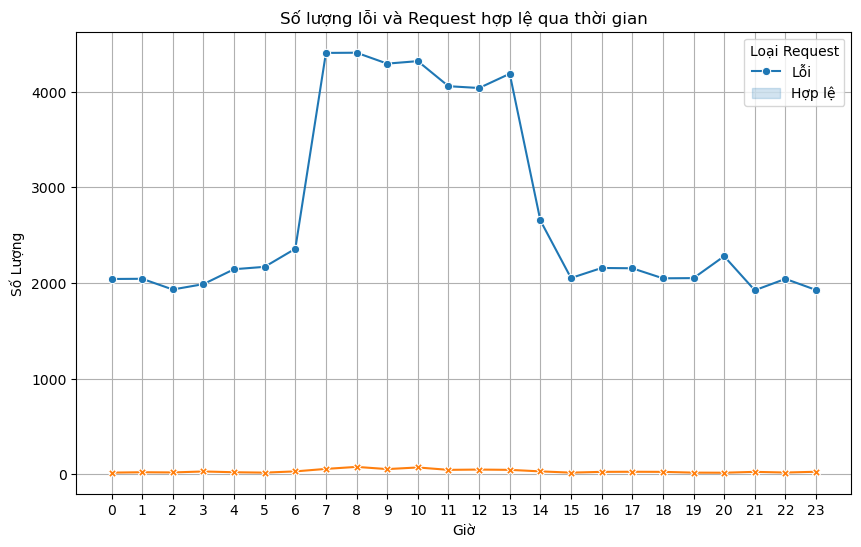

In [9]:
visualizer.plot_errors_over_time()

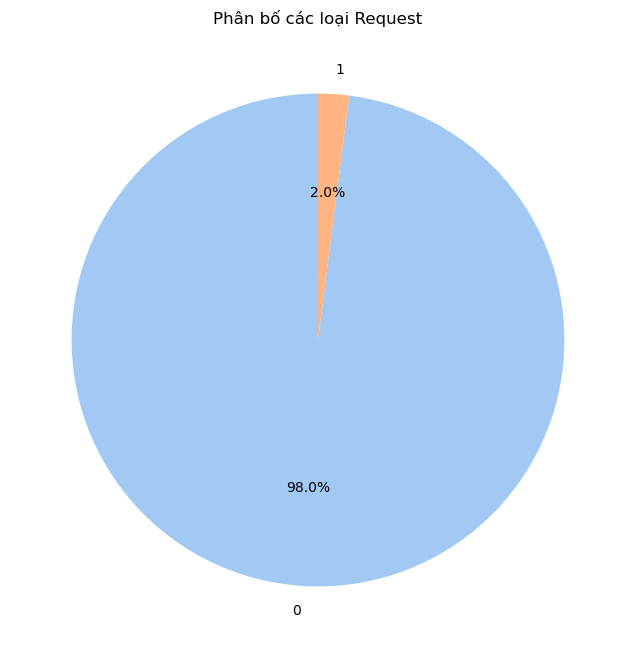

In [10]:
visualizer.plot_request_distribution()

/Users/phamthiphuongthuy/Desktop/Intern/server_log/main/module/visualize.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_bytes_sent.index, y=hourly_bytes_sent.values, palette="viridis")


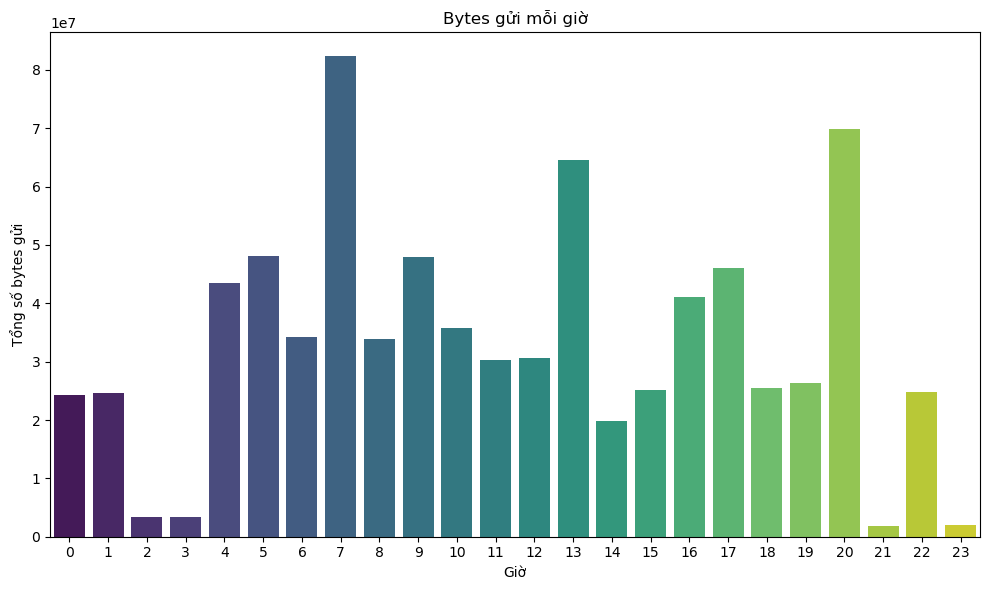

In [11]:
visualizer.plot_bytes_sent_per_hour()

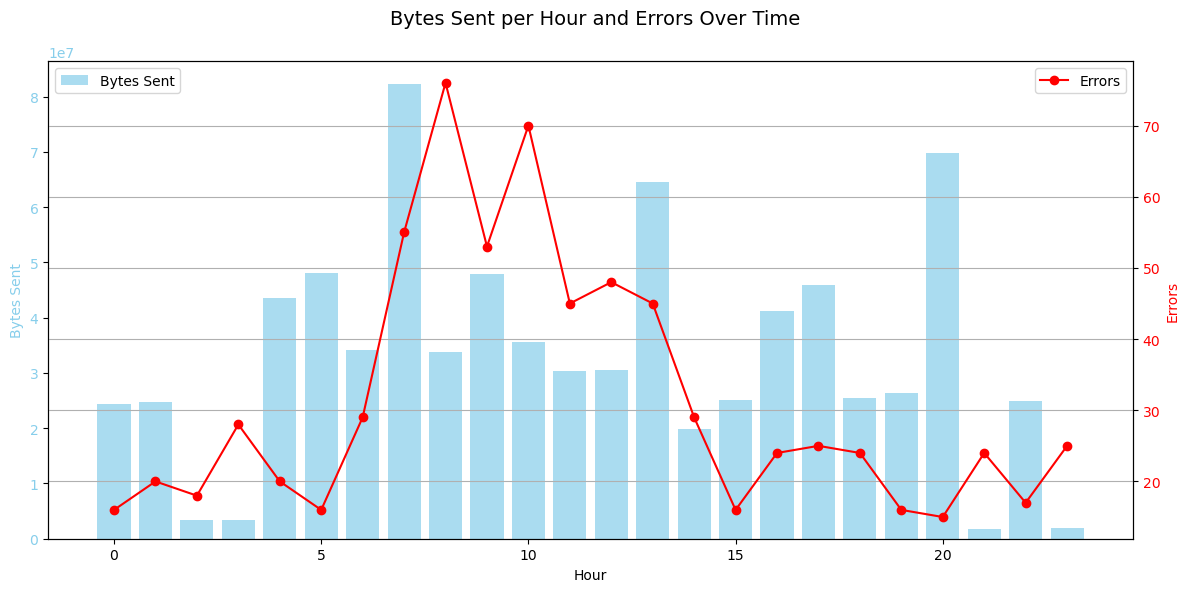

In [12]:
visualizer.plot_combined_chart()

/Users/phamthiphuongthuy/Desktop/Intern/server_log/main/module/visualize.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=status_counts.index, y=status_counts.values, palette="viridis")


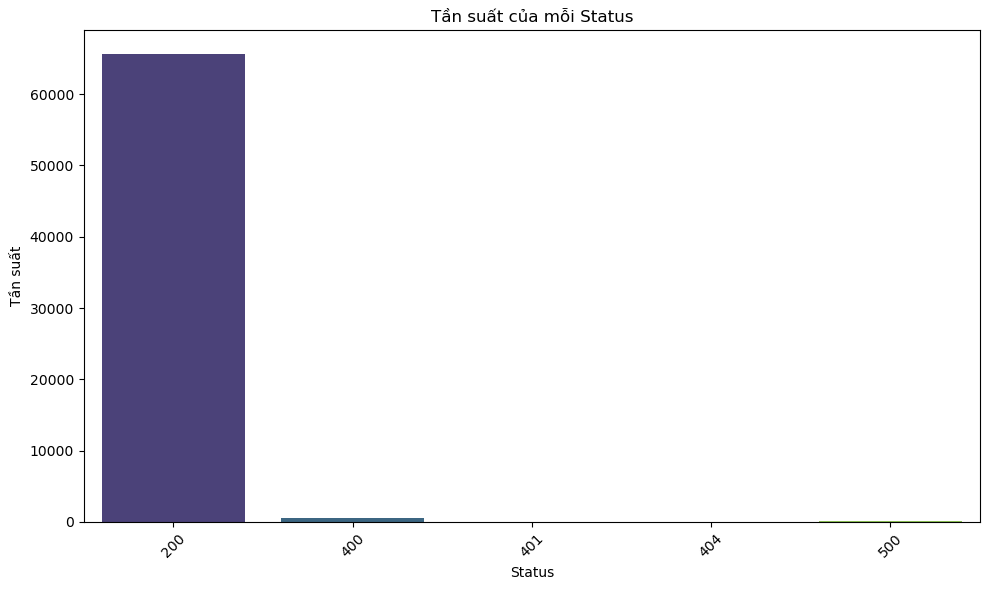

In [13]:
visualizer.plot_status_distribution()

In [14]:
df['error'] = df['status'].apply(lambda x: 1 if x != 200 else 0)

# Drop irrelevant columns and prepare cleaned data for embedding
cleaned_data = df.drop(columns=["std", "referer"], axis=1)

In [15]:
df

,std,remote_address,datetime,method,path,status,bytes_sent,referer,user_agent,day,hour,month,error
0,0,127.0.0.1,2024-11-30 06:51:41+00:00,0,/status,200,1164,-,kong-ingress-controller/3.3.1,30,6,11,0
1,1,10.244.3.1,2024-11-30 06:51:42+00:00,0,/status,200,1165,-,kube-probe/1.27,30,6,11,0
2,1,10.244.3.1,2024-11-30 06:51:42+00:00,0,/status/ready,200,19,-,kube-probe/1.27,30,6,11,0
3,0,127.0.0.1,2024-11-30 06:51:44+00:00,0,/status,200,1164,-,kong-ingress-controller/3.3.1,30,6,11,0
4,0,127.0.0.1,2024-11-30 06:51:47+00:00,0,/status,200,1164,-,kong-ingress-controller/3.3.1,30,6,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66406,0,127.0.0.1,2024-12-01 14:19:02+00:00,0,/status,200,1166,-,kong-ingress-controller/3.3.1,1,14,12,0
66407,0,10.244.2.197,2024-12-01 14:19:04+00:00,0,/metrics,200,192072,-,otelcol-contrib/0.89.0,1,14,12,0
66408,0,127.0.0.1,2024-12-01 14:19:05+00:00,0,/status,200,1166,-,kong-ingress-controller/3.3.1,1,14,12,0
66409,0,10.244.5.196,2024-12-01 14:19:07+00:00,0,/metrics,200,192072,-,otelcol-contrib/0.89.0,1,14,12,0


DỰ ĐOÁN DÙNG PHƯƠNG PHÁP RANDOM FOREST

In [16]:
df.describe()

,std,method,status,bytes_sent,day,hour,month,error
count,66411.000000,66411.000000,66411.000000,66411.000000,66411.000000,66411.000000,66411.000000,66411.000000
mean,0.341058,0.020238,202.418816,11882.695909,16.885787,11.129165,11.452214,0.011354
std,0.474068,0.140813,22.853877,44214.657697,14.433736,6.103731,0.497715,0.105947
min,0.000000,0.000000,200.000000,0.000000,1.000000,0.000000,11.000000,0.000000
25%,0.000000,0.000000,200.000000,1164.000000,1.000000,7.000000,11.000000,0.000000
50%,0.000000,0.000000,200.000000,1165.000000,30.000000,11.000000,11.000000,0.000000
75%,1.000000,0.000000,200.000000,1166.000000,30.000000,16.000000,12.000000,0.000000
max,1.000000,1.000000,500.000000,671207.000000,30.000000,23.000000,12.000000,1.000000


In [17]:
number_df = df.drop(['std','remote_address','datetime','path','referer','user_agent',], axis=1)

In [18]:
number_df

,method,status,bytes_sent,day,hour,month,error
0,0,200,1164,30,6,11,0
1,0,200,1165,30,6,11,0
2,0,200,19,30,6,11,0
3,0,200,1164,30,6,11,0
4,0,200,1164,30,6,11,0
...,...,...,...,...,...,...,...
66406,0,200,1166,1,14,12,0
66407,0,200,192072,1,14,12,0
66408,0,200,1166,1,14,12,0
66409,0,200,192072,1,14,12,0


In [19]:
correlation = number_df.corr()

In [20]:
%pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


<Axes: >

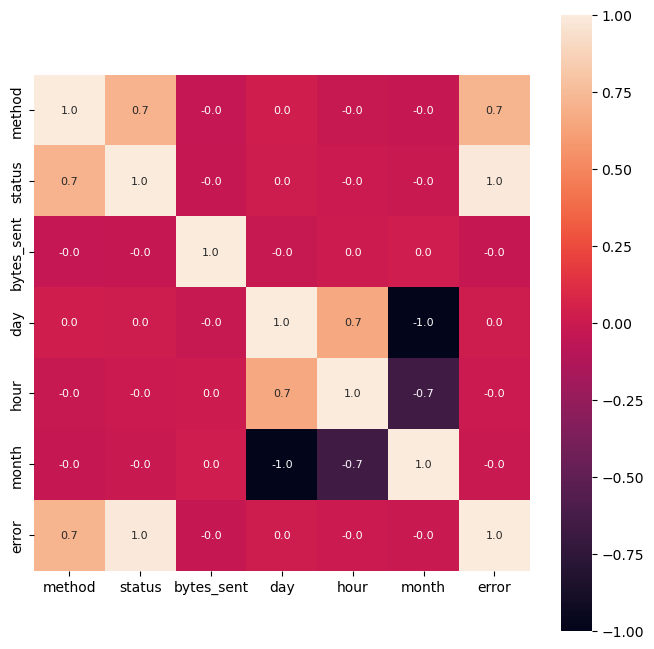

In [21]:

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (8,8))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f',annot=True, annot_kws={'size':8})

In [22]:
print(correlation['error'])

method        0.715354
status        0.987645
bytes_sent   -0.028696
day           0.010843
hour         -0.003432
month        -0.010843
error         1.000000
Name: error, dtype: float64


/var/folders/2f/l2t6rv7j4pjfjqq_ymr89c2r0000gn/T/ipykernel_18088/3358081752.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['hour'],color='green')


<Axes: xlabel='hour', ylabel='Density'>

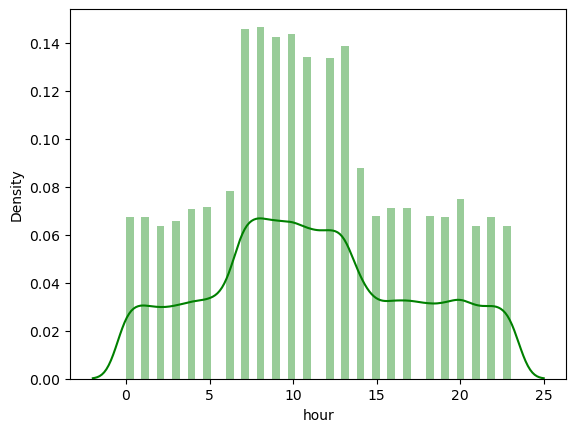

In [23]:
sns.distplot(df['hour'],color='green')

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [25]:
X = df.drop(['remote_address','path','user_agent','referer','bytes_sent','datetime','std','error'], axis=1)
y = df['error']

In [26]:
X

,method,status,day,hour,month
0,0,200,30,6,11
1,0,200,30,6,11
2,0,200,30,6,11
3,0,200,30,6,11
4,0,200,30,6,11
...,...,...,...,...,...
66406,0,200,1,14,12
66407,0,200,1,14,12
66408,0,200,1,14,12
66409,0,200,1,14,12


In [27]:
y

0        0
1        0
2        0
3        0
4        0
        ..
66406    0
66407    0
66408    0
66409    0
66410    0
Name: error, Length: 66411, dtype: int64

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [29]:
rf_regressor = RandomForestRegressor(n_estimators=100)

In [30]:
rf_regressor.fit(X_train,y_train)

RandomForestRegressor()

In [31]:
y_pred = rf_regressor.predict(X_test)

In [32]:
# R squared error
error_score = metrics.r2_score(y_test, y_pred)
print("R squared error : ", error_score)

R squared error :  1.0


In [33]:
y_test_list = list(y_test)

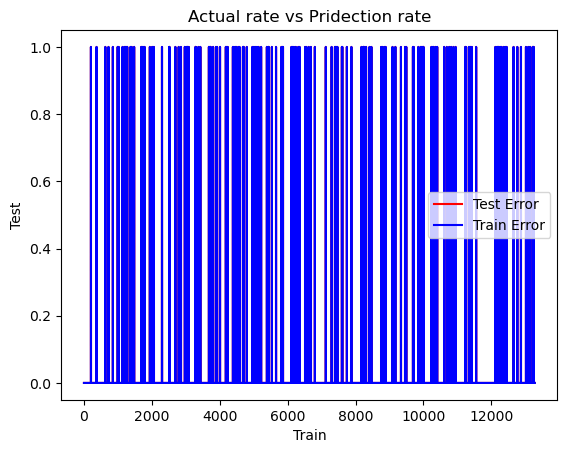

In [34]:
plt.plot(y_test_list, color='red', label = 'Test Error')
plt.plot(y_pred, color='blue', label='Train Error')
plt.title('Actual rate vs Pridection rate')
plt.xlabel('Train')
plt.ylabel('Test')
plt.legend()
plt.show()